In [1]:
import urllib.request
import json
import numpy as np
import pandas as pd
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [24]:
def custom_analyzer(doc):
    return doc

cardVec = load('matrix_data/cardVec_4k_20dim.joblib')
deckVecorizer = load('matrix_data/deckVectorizer_4k_15K.joblib')

In [25]:
deckVecorizer

TfidfVectorizer(analyzer=<function custom_analyzer at 0x0000023E0C4BC160>,
                lowercase=False,
                vocabulary=['Strike_R', 'Bash', 'Anger', 'Body Slam', 'Clash',
                            'Cleave', 'Clothesline', 'Headbutt', 'Heavy Blade',
                            'Iron Wave', 'Perfected Strike', 'Pommel Strike',
                            'Sword Boomerang', 'Thunderclap', 'Twin Strike',
                            'Wild Strike', 'Blood for Blood', 'Carnage',
                            'Dropkick', 'Hemokinesis', 'Pummel', 'Rampage',
                            'Reckless Charge', 'Searing Blow', 'Sever Soul',
                            'Uppercut', 'Whirlwind', 'Bludgeon', 'Feed',
                            'Fiend Fire', ...])

In [26]:
data_url = 'https://raw.githubusercontent.com/KU81-ComSci-ProjectEnd-GameCard/main/master/Predictor/data/processed_data/picked_4k_15k.json'
with urllib.request.urlopen(data_url) as url:
    pick_js = json.loads(url.read().decode())
pick = pd.DataFrame(pick_js)

In [27]:
pick

,deck,picked
0,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Bludgeon
1,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Flex
2,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Anger
3,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Reckless Charge
4,"[Strike_R, Strike_R, Strike_R, Strike_R, Strik...",Flex
...,...,...
15525,"[Strike_R, Strike_R, Defend_R, Defend_R, Defen...",Pommel Strike
15526,"[Defend_R, Defend_R, Defend_R, Defend_R, Bash,...",Offering
15527,"[Defend_R, Defend_R, Defend_R, Bash, Body Slam...",Shrug It Off
15528,"[Defend_R, Defend_R, Defend_R, Bash, Body Slam...",Impervious


kerass

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization

In [29]:
X = deckVecorizer.fit_transform(pick.deck.tolist())
X = X.toarray()
y = [cardVec[picked] for picked in pick.picked ]
y_card = pick.picked 

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_card = np.array(y_card, dtype= str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, yC_train,yC_test = train_test_split(X, y,y_card, test_size=0.2, random_state=102)

In [30]:
X.shape

(15530, 257)

In [31]:
y.shape

(15530, 20)

In [32]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def cosine_similarity_loss(y_true, y_pred):
    # Compute the dot product between y_true and y_pred
    dot_product = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=-1)
    
    # Compute the norm of y_true and y_pred
    norm_y_true = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=-1))
    norm_y_pred = tf.sqrt(tf.reduce_sum(tf.square(y_pred), axis=-1))
    
    # Compute cosine similarity
    cosine_similarity = dot_product / (norm_y_true * norm_y_pred + tf.keras.backend.epsilon())
    
    # Cosine similarity ranges from -1 to 1, so we convert it to a loss value by subtracting from 1
    return 1 - cosine_similarity

In [60]:
model = Sequential([
    Input(shape=(257,)),# Define the input shape
    
    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),     
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),      
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'), 
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(20)           
])
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss= cosine_similarity_loss, metrics=['mae']) 

In [61]:
class PrintLossEveryTenEpochs(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch + 1}, Loss: {logs["loss"]:.4f}')

In [62]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32,validation_split=0.3, verbose=0, callbacks=[PrintLossEveryTenEpochs()])

Epoch 1, Loss: 0.5422
Epoch 2, Loss: 0.2779
Epoch 3, Loss: 0.2694
Epoch 4, Loss: 0.2662
Epoch 5, Loss: 0.2641
Epoch 6, Loss: 0.2622
Epoch 7, Loss: 0.2613
Epoch 8, Loss: 0.2598
Epoch 9, Loss: 0.2591
Epoch 10, Loss: 0.2583


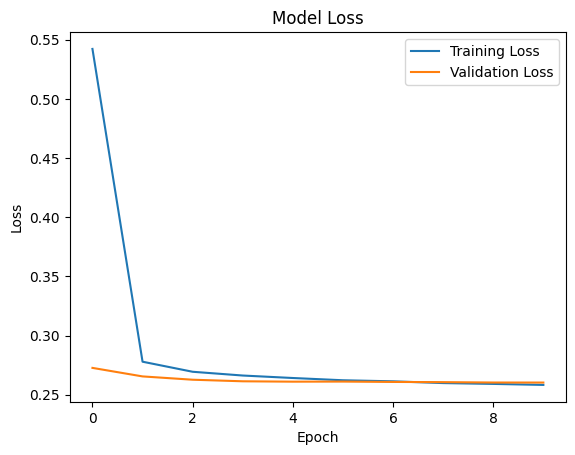

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [47]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    similarity = dot_product / (norm1 * norm2)
    return similarity

In [48]:

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=1)

# If loss is a list, print the first element as the test loss
print(f'Test Loss: {loss[0]:.4f}' if isinstance(loss, list) else f'Test Loss: {loss:.4f}')

# Make predictions (optional)
predictions = model.predict(X_test)
simility_test = list()
for pred, pick_card in zip(predictions , yC_test):
    simility_test.append(cosine_similarity(pred, cardVec[pick_card]))

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.3089 - mae: 0.3599
Test Loss: 0.3008
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
mt = pd.DataFrame()

In [50]:
mt['similate'] = simility_test

In [51]:
mt['similate'] = simility_test
mt.similate.describe()

count    3106.000000
mean        0.732965
std         0.136204
min         0.196651
25%         0.645050
50%         0.754197
75%         0.839294
max         0.960210
Name: similate, dtype: float64